In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv("/Users/mac/Downloads/Building Energy/train.csv")
building = pd.read_csv("/Users/mac/Downloads/Building Energy/building_metadata.csv")
weather = pd.read_csv("/Users/mac/Downloads/Building Energy/weather_train.csv")

In [3]:
train = train.merge(building, on="building_id", how="left")
train = train.merge(weather, on=["site_id", "timestamp"], how="left")


In [4]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = train["timestamp"].dt.hour
train["month"] = train["timestamp"].dt.month


In [5]:
train.drop(columns=["timestamp", "building_id"], inplace=True)

In [6]:
#Site_id are a little correlated to target columns since it describe locations
#Site_id 0 meter reading are measured as Kbtu so this needs to convert the same units with other sites
train.loc[train['site_id']==0, 'meter_reading'] *= 0.2931


In [7]:
num_cols = [
    'meter', 'site_id', 'square_feet',
    'year_built', 'floor_count',
    'air_temperature', 'cloud_coverage', 'dew_temperature',
    'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed',
    'hour', 'month'
]

cat_cols = ["primary_use"]

train[num_cols] = train[num_cols].fillna(train[num_cols].median())

In [8]:
train = train.sample(n=200000,random_state=42)

In [9]:
#train.corr(numeric_only=True)

In [10]:
X = train.drop(columns=["meter_reading"])
y = np.log1p(train["meter_reading"])

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [12]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [14]:
pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", LinearRegression())
    ]
)


<Axes: >

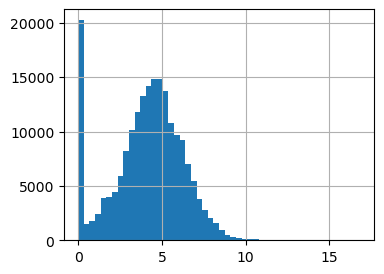

In [15]:
y.hist(figsize=(4,3),bins=50)


In [16]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)


In [17]:
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)

#pred = np.expm1(pipeline.predict(X_test))
#pred = np.maximum(0,pred)



In [18]:
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print(mse)
print(rmse)

3.616385237384594
1.9016795832591236


In [19]:
with open("building_pipeline_app1.1.2.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("Pipeline model saved")

Pipeline model saved
